## Load processed data

In [1]:
import yaml
import numpy as np
import torch
from collections import Counter
from torch import nn
from matplotlib import pyplot as plt
import torch.nn.functional as F
%matplotlib inline
import copy
import argparse
from helper import data_generator
import sys; sys.argv=['']; del sys
file = 'args/sst/sst_attn_simple.yaml'
with open(file) as f:
    args = yaml.load(f, Loader=yaml.Loader)
    parser = argparse.ArgumentParser(description='attention')
    config = parser.parse_args()
    for k, v in args['common'].items():
        setattr(config, k, v)

In [2]:
import pickle
with open(config.dic_path, 'rb') as f:
    vocab, word2id, id2word = pickle.load(f)

In [3]:
train_dg = data_generator(config, config.train_path)
train_eval_dg = data_generator(config, config.train_path, False)
dev_dg = data_generator(config, config.dev_path, False)
test_dg = data_generator(config, config.test_path, False)

In [4]:
len(vocab)

16174

## Model

In [5]:
#scale = 1
from attn_model import SimpleAttnClassifier

In [6]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
def evaluate(dg, model):
    #Make prediction
    model.eval()
    count = 0
    #record the gold and the prediction
    gold_labels = []
    pred_labels = []
    dg.reset_samples()
    while dg.index<dg.data_len:
        sent_ids, label_list, sent_lens = next(dg.get_ids_samples())
        outputs, _, _, _ =  model(sent_ids.to(device), sent_lens.to(device))
        preds = (outputs>0.5).squeeze()

        gold_labels += list(label_list.cpu().numpy())
        pred_labels += list(preds.cpu().numpy())
        num = (preds.cpu() == label_list.bool()).sum().cpu().item()
        count += num
        #print(num)
    accuracy = count*1.0/dg.data_len
    f1 = f1_score(gold_labels, pred_labels, average='binary')
    precision = precision_score(gold_labels, pred_labels, average='binary')
    recall = recall_score(gold_labels, pred_labels, average='binary')
    print('Index', dg.index)
    print('Evaluation accuracy:', accuracy)
    return accuracy

## Training

In [7]:
torch.manual_seed(222)
loss_function = nn.BCELoss()
scale = 10
model = SimpleAttnClassifier(config.vocab_size, 100, 100, 1, scale)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.02, weight_decay=0.0000, lr_decay=0.001)

In [8]:
loop_num = int(train_dg.data_len/config.batch_size)+1
best_model = None
best_acc = 0
for i in range(40):
    print('Epoch:', i)
    print('#'*20)

    total_loss = 0
    model.train()
    #shuffle the training set given the random seed
    train_dg.shuffle_data()
    #sequential sampling, use all the dataset
    train_dg.reset_samples()
    #model.embeddings.required_grad = config.update_emb
    for j in range(loop_num):
        model.zero_grad()
        # generate dataset
        sent_ids,  label_list, sent_lens = next(train_dg.get_sequential_ids_samples())
        ####check whether the seed works
        #if (i<2)&(j==0):
            #print(sent_ids)
        preds, _, _, _ =  model(sent_ids.to(device), sent_lens.to(device))
        temp = model.decoder(model.V.transpose(0, 1))
        loss = loss_function(preds.squeeze(), label_list.to(device).float())#+ 0.0001*temp[0, 0].abs()
        #loss = loss_function(preds.squeeze(), label_list.to(device).float())

        # Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.cpu().item()*len(sent_ids)
        if j%50 == 0:
            l = loss.cpu().item()
            print('Sample Loss:{:.3f}'.format(l))

    #Dev Evaluation
#     print('Training Accuracy')
    evaluate(train_eval_dg, model)
    print('Dev Accuracy')
    dev_acc = evaluate(dev_dg, model)
    if best_acc < dev_acc:
        best_acc = dev_acc
        best_model = copy.deepcopy(model)

Epoch: 0
####################
Sample Loss:0.695
Sample Loss:0.620
Index 6920
Evaluation accuracy: 0.7566473988439306
Dev Accuracy
Index 872
Evaluation accuracy: 0.7350917431192661
Epoch: 1
####################
Sample Loss:0.599
Sample Loss:0.482
Index 6920
Evaluation accuracy: 0.8228323699421966
Dev Accuracy
Index 872
Evaluation accuracy: 0.768348623853211
Epoch: 2
####################
Sample Loss:0.504
Sample Loss:0.435
Index 6920
Evaluation accuracy: 0.8625722543352601
Dev Accuracy
Index 872
Evaluation accuracy: 0.786697247706422
Epoch: 3
####################
Sample Loss:0.407
Sample Loss:0.315
Index 6920
Evaluation accuracy: 0.8854046242774567
Dev Accuracy
Index 872
Evaluation accuracy: 0.7855504587155964
Epoch: 4
####################
Sample Loss:0.376
Sample Loss:0.276
Index 6920
Evaluation accuracy: 0.9030346820809249
Dev Accuracy
Index 872
Evaluation accuracy: 0.7912844036697247
Epoch: 5
####################
Sample Loss:0.291
Sample Loss:0.327
Index 6920
Evaluation accuracy: 0.91

In [9]:
#Test performance       
print('Best dev:', best_acc)
test_acc = evaluate(test_dg, best_model)

Best dev: 0.8004587155963303
Index 1821
Evaluation accuracy: 0.8182317408017573


## Select Tokens
We will select polarity tokens as well as neutral tokens based on their frequency across different types of instances.

In [18]:
texts, labels = zip(*train_dg.data_batch)
text_length = [len(t) for t in texts]

In [19]:
#Calculate the times that a token appears in a specified label

In [20]:
word_label_pair = []
word_doc_freq = {}
vocab = []
for i, text in enumerate(texts):
    for w in text:
        word_doc_freq[w] = word_doc_freq.get(w, 0) + 1
        
for i, text in enumerate(texts):
    label = labels[i]
    for w in text:
        word_doc_freq[w] = word_doc_freq.get(w, 0) + 1
    word_label_pair += [(id2word[item], label) for item in text]
    vocab += [id2word[item] for item in text]
vocab = set(vocab)

In [21]:
word_label_pair_freq = Counter(word_label_pair)
#Get the ratio, a word appears in positive sentences: a word appears in negative sentences
token_freq_pos = {}
token_freq_neg = {}
pos_tokens = []
neg_tokens = []
neutral_tokens = []
total_diff_freq = 0
#Note here, 1 means positive and 0 means negative
for w in vocab:
    freq_pos = word_label_pair_freq[(w, 1)]
    freq_neg = word_label_pair_freq[(w, 0)]
    token_freq_pos[word2id[w]] = freq_pos
    token_freq_neg[word2id[w]] = freq_neg

    if freq_pos-freq_neg !=0:
        #We use 10
        rate = (freq_pos-freq_neg)/(freq_pos+freq_neg)*1.0
        if rate>0.5 and freq_pos>5:#positive tokens
            pos_tokens.append(w)
        if rate<-0.5 and freq_neg>5:
            neg_tokens.append(w)

    if abs(freq_pos-freq_neg)/(freq_pos+freq_neg)<0.1 and abs(freq_pos-freq_neg)<5:
        neutral_tokens.append(w)

In [22]:
#print(pos_tokens)

In [23]:
print(len(pos_tokens), len(neg_tokens), len(neutral_tokens))

412 265 1384


In [24]:
pos_tokens_index = [word2id[w] for w in pos_tokens]
neg_tokens_index = [word2id[w] for w in neg_tokens]
neutral_tokens_index = [word2id[w] for w in neutral_tokens]
pos_tokens_index_label1 = [token_freq_pos[w] for w in pos_tokens_index]
pos_tokens_index_label0 = [token_freq_neg[w] for w in pos_tokens_index]
pos_tokens_index_diff = [token_freq_pos[w]-token_freq_neg[w] for w in pos_tokens_index]

neg_tokens_index_label1 = [token_freq_pos[w] for w in pos_tokens_index]
neg_tokens_index_label0 = [token_freq_neg[w] for w in pos_tokens_index]
neg_tokens_index_diff = [token_freq_pos[w]-token_freq_neg[w] for w in neg_tokens_index]

## Visualization

In [29]:
def get_sentiment_scores(model, pos_tokens_index, neg_tokens_index, neutral_tokens_index):
    pos_token_sentiment_score = []
    for w in pos_tokens_index:
        seq_embs = model.embeddings(torch.LongTensor([w]).to(device))                        
        hidden_vecs = model.affine(seq_embs)
        hidden_vecs = seq_embs
        pos_token_sentiment_score.append(model.decoder(hidden_vecs).item())

    neg_token_sentiment_score = []
    for w in neg_tokens_index:
        seq_embs = model.embeddings(torch.LongTensor([w]).to(device))                        
        hidden_vecs = model.affine(seq_embs)
        hidden_vecs = seq_embs
        neg_token_sentiment_score.append(model.decoder(hidden_vecs).item())

    neutral_token_sentimetn_score = []
    for w in neutral_tokens_index:
        seq_embs = model.embeddings(torch.LongTensor([w]).to(device))                        
        hidden_vecs = model.affine(seq_embs)
        hidden_vecs = seq_embs
        neutral_token_sentimetn_score.append(model.decoder(hidden_vecs).item())

    plt.plot(pos_tokens_index, pos_token_sentiment_score, '+',label='Pos')
    plt.plot(neg_tokens_index, neg_token_sentiment_score, '.', label='Neg')
    plt.plot(neutral_tokens_index, neutral_token_sentimetn_score, 'x', label='Neutral')
    plt.xlabel('Token Index')
    plt.ylabel('Polarity Score')
    plt.grid(linestyle='--')
    plt.legend()
    return pos_token_sentiment_score, neg_token_sentiment_score, neutral_token_sentimetn_score

In [42]:
def get_attn_scores(model, pos_tokens_index, neg_tokens_index, neutral_tokens_index):
    pos_token_attn_score = []
    for w in pos_tokens_index:
        seq_embs = model.embeddings(torch.LongTensor([w]).to(device))                        
        hidden_vecs = model.affine(seq_embs)
        #hidden_vecs = torch.tanh(model.attn_linear(hidden_vecs))
        hidden_vecs = seq_embs
        attn_score = torch.matmul(hidden_vecs, model.V)
        #attn_score = torch.matmul(hidden_vecs, model.decoder.weight.transpose(0, 1))
        pos_token_attn_score.append(attn_score[0].item()/scale)

    neg_token_attn_score = []
    for w in neg_tokens_index:
        seq_embs = model.embeddings(torch.LongTensor([w]).to(device))                        
        hidden_vecs = model.affine(seq_embs)
        #hidden_vecs = torch.tanh(model.attn_linear(hidden_vecs))
        hidden_vecs = seq_embs
        attn_score = torch.matmul(hidden_vecs, model.V)
        #attn_score = torch.matmul(hidden_vecs, model.decoder.weight.transpose(0, 1))
        neg_token_attn_score.append(attn_score[0].item()/scale)

    neutral_token_attn_score = []
    for w in neutral_tokens_index:
        seq_embs = model.embeddings(torch.LongTensor([w]).to(device))                        
        hidden_vecs = model.affine(seq_embs)
        #hidden_vecs = torch.tanh(model.attn_linear(hidden_vecs))
        hidden_vecs = seq_embs
        attn_score = torch.matmul(hidden_vecs, model.V)
        #attn_score = torch.matmul(hidden_vecs, model.decoder.weight.transpose(0, 1))
        neutral_token_attn_score.append(attn_score[0].item()/scale)
        
    plt.plot(pos_tokens_index, pos_token_attn_score, '+',label='Pos')
    plt.plot(neg_tokens_index, neg_token_attn_score, '.', label='Neg')
    plt.plot(neutral_tokens_index, neutral_token_attn_score, 'x', label='Neutral')

    plt.xlabel('Token Index')
    plt.ylabel('Attention Score')
    plt.grid(linestyle='--')

    plt.legend()
    return pos_token_attn_score, neg_token_attn_score, neutral_token_attn_score

In [31]:
#torch.save(best_model,'imgs/sst_scores_img/best_model_10.pt' )

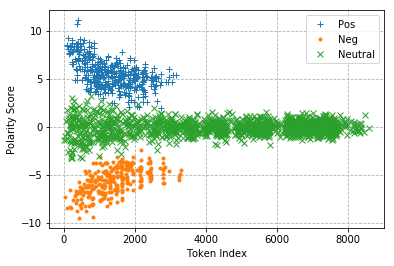

In [32]:
_ = get_sentiment_scores(best_model, pos_tokens_index, neg_tokens_index, neutral_tokens_index)

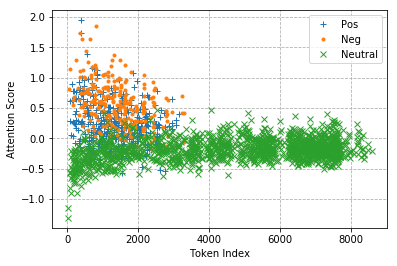

In [33]:
_, _, neutral_token_attn_score= get_attn_scores(best_model, pos_tokens_index, neg_tokens_index, neutral_tokens_index)

## Calculate attention weights

In [34]:
dg = test_dg
dg.reset_samples()
model.eval()
  
best_model.eval()
def generate_weights(dg, model):
    #model.embeddings.required_grad = config.update_emb
    important_word_inds = []
    token_attn_weights = {}  
    while dg.index<dg.data_len:
        # generate dataset
        sent_ids,  label_list, sent_lens = next(dg.get_sequential_ids_samples())
        ####check whether the seed works
        #if (i<2)&(j==0):
            #print(sent_ids)
        preds, _, attn, _ =  best_model(sent_ids.to(device), sent_lens.to(device))
        for i in range(len(sent_ids)):
            for j in range(sent_lens[i]):
                w = sent_ids[i, j].item()
                token_attn_weights[w] = token_attn_weights.get(w, []) + [attn[i, 0, j].item()]
        #Get important words
        values, indices = torch.topk(attn.squeeze(1), k=2, dim=1, largest=True, sorted=True, out=None)
        for i in range(len(indices)):
            important_word_inds += list(sent_ids[i][indices[i]].numpy())
    return token_attn_weights

In [151]:
# important_words = [id2word[item] for item in important_word_inds]
# from collections import Counter
# import_word_freq = Counter(important_words)

In [35]:
token_attn_weights = generate_weights(test_dg, best_model)

In [36]:
avg_pos_attn_weights = {}
for w in pos_tokens_index:
    if w in token_attn_weights.keys():
        avg_pos_attn_weights[w] = np.mean(token_attn_weights[w])

In [37]:
avg_neg_attn_weights = {}
for w in neg_tokens_index:
    if w in token_attn_weights.keys():
        avg_neg_attn_weights[w] = np.mean(token_attn_weights[w])

In [38]:
avg_neutral_attn_weights = {}
for w in neutral_tokens_index:
    if w in token_attn_weights.keys():
        avg_neutral_attn_weights[w] = np.mean(token_attn_weights[w])

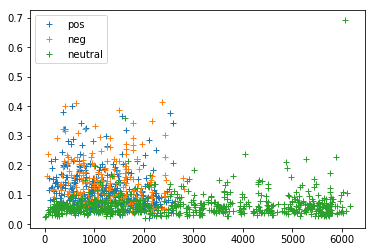

In [39]:
data = []
keys, avg_weights = zip(*avg_pos_attn_weights.items())
data += [avg_weights]
plt.plot(keys, avg_weights, '+', label='pos')
keys, avg_weights = zip(*avg_neg_attn_weights.items())
data += [avg_weights]
plt.plot(keys, avg_weights, '+', label='neg')
keys, avg_weights = zip(*avg_neutral_attn_weights.items())
data += [avg_weights]
plt.plot(keys, avg_weights, '+', label='neutral')
plt.legend()

Text(0,0.5,'Average Attention Weight')

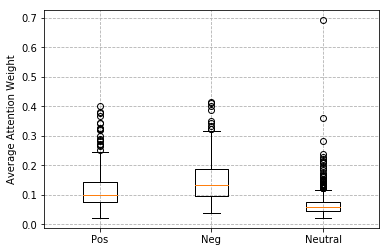

In [41]:
plt.boxplot(data)
plt.grid(linestyle='--')
plt.xticks([1, 2, 3], ['Pos', 'Neg', 'Neutral'])
plt.ylabel('Average Attention Weight')
#plt.savefig("imgs/sst_scores_img/sst_attn_weight_d"+str(scale)+".pdf",  dpi=900)